# Gemini 2.5 Pro 
---

| Parameter         | Value                                         | Description                                                                                 |
|-------------------|-----------------------------------------------|---------------------------------------------------------------------------------------------|
| mode              | inference                                     | Mode of operation (inference, training)                                                     |
| model_id          | gemini-2.5-flash-preview-05-20                | Model ID                                                                                    |
| type              | LLM                                           | Type of model (convML for conventional ML, convDL for deep learning, LLM for large language models) |
| verbose           | 2                                             | Verbosity level                                                                             |
| max_new_tokens    | 300                                           | Maximum number of new tokens to generate                                                    |
| max_length        | 30000                                         | Maximum length of input sequences                                                           |
| temperature       | 0.4                                           | Temperature for sampling (0.0 = greedy sampling)                                            |
| thinking_budget   | 1500                                             | 0 = no thinking budget, -1 = dynamic thinking budget                                        |

In [1]:
# Imports
import os
import sys
import ipywidgets as widgets
from IPython.display import display

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

## Analysis of different prompting approaches
---

In [2]:
import pandas as pd


model_id = "gemini2p5pro"
base_output_dir = (
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark"
)
model_output_dir = os.path.join(base_output_dir, "llms", model_id)
results_output_dir = os.path.join(base_output_dir, r"results_output")


prompt_approaches = os.listdir(model_output_dir)
print(prompt_approaches)

# Try to load results_dict from json before calculating
results_loaded = False
results_output_jsons = os.path.join(results_output_dir, "jsons")
results_json_path = f"{model_id}_results.json"

if not results_loaded:
    best_prompt_approach = None

    results_dict = {}
    cost_df = pd.DataFrame()

    for prompt_approach in prompt_approaches:

        if not os.path.isdir(os.path.join(model_output_dir, prompt_approach)):
            continue

        print("=" * 50)
        print(f"\nPrompting Approach {prompt_approach}")

        cat_files = LLMAnalyzer.categorize_files(
            [os.path.join(model_output_dir, prompt_approach)],
            verbose=False,
        )

        df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"], verbose=True)
        summary = LLMAnalyzer.print_approach_summary(
            df_mdata, input_token_cost=1.25, output_token_cost=10
        )

        # Filter for final prediction step if agent is used

        if "Step Name" in df_mdata.columns:

            df_mdata = df_mdata[
                df_mdata["Step Name"] == "final_prediction"
            ].reset_index(drop=True)

        ps = PULSEScoreCalculator()

        pulse_score = ps.calculate_pulse_score_from_raw_data(
            df=df_mdata,
        )
        pulse_score["model_id"] = model_id
        pulse_score["prompting_id"] = prompt_approach

        pulse_score_temp = pulse_score["overall"]["overall_score"]

        results_dict[prompt_approach] = pulse_score
        cost_df[prompt_approach] = [
            summary["input_cost"].sum(),
            summary["output_cost"].sum(),
            summary["thinking_cost"].sum(),
            summary["total_cost"].sum(),
        ]
        cost_df.index = ["input_cost", "output_cost", "thinking_cost", "total_cost"]

        if best_prompt_approach is None or pulse_score_temp > best_prompt_approach[1]:

            best_prompt_approach = (prompt_approach, pulse_score_temp)

    display(cost_df)

    print(
        f"\nBest prompt approach: {best_prompt_approach[0]} with PULSE score: {best_prompt_approach[1]}"
    )

    # Save results as json. Uses pulse-result format
    json_output_path = os.path.join(results_output_jsons, f"{model_id}_results.json")
    LLMAnalyzer.save_results_dict_as_json(
        results_dict, model_output_dir, json_output_path
    )

['hybrid_reasoning_agent_preprocessor', 'zhu_2024b_zero_shot_preprocessor']

Prompting Approach hybrid_reasoning_agent_preprocessor
Extracting metadata from files:
Model Name: Gemini2p5pro, Task: aki, Dataset: eicu, Timestamp: 20250712_173710
Model Name: Gemini2p5pro, Task: aki, Dataset: hirid, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: aki, Dataset: miiv, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: mortality, Dataset: eicu, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: mortality, Dataset: hirid, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: mortality, Dataset: miiv, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: sepsis, Dataset: eicu, Timestamp: 20250710_103102
Model Name: Gemini2p5pro, Task: sepsis, Dataset: hirid, Timestamp: 20250710_103102
Model Name: Gemini2p5pro, Task: sepsis, Dataset: miiv, Timestamp: 20250710_103102


--- Approach Summary ---
- Number of Samples: 6188
- Number of Requests: 27392
- Total Input 

,hybrid_reasoning_agent_preprocessor,zhu_2024b_zero_shot_preprocessor
input_cost,23.406643,32.996686
output_cost,38.477170,2.966580
thinking_cost,0.000000,941.151150
total_cost,61.883812,977.114416



Best prompt approach: hybrid_reasoning_agent_preprocessor with PULSE score: 51.47272099621813
Saved 18 result entries to C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\results_output\jsons\gemini2p5pro_results.json


Summary Metrics of all Prompting Appraches

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:916: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


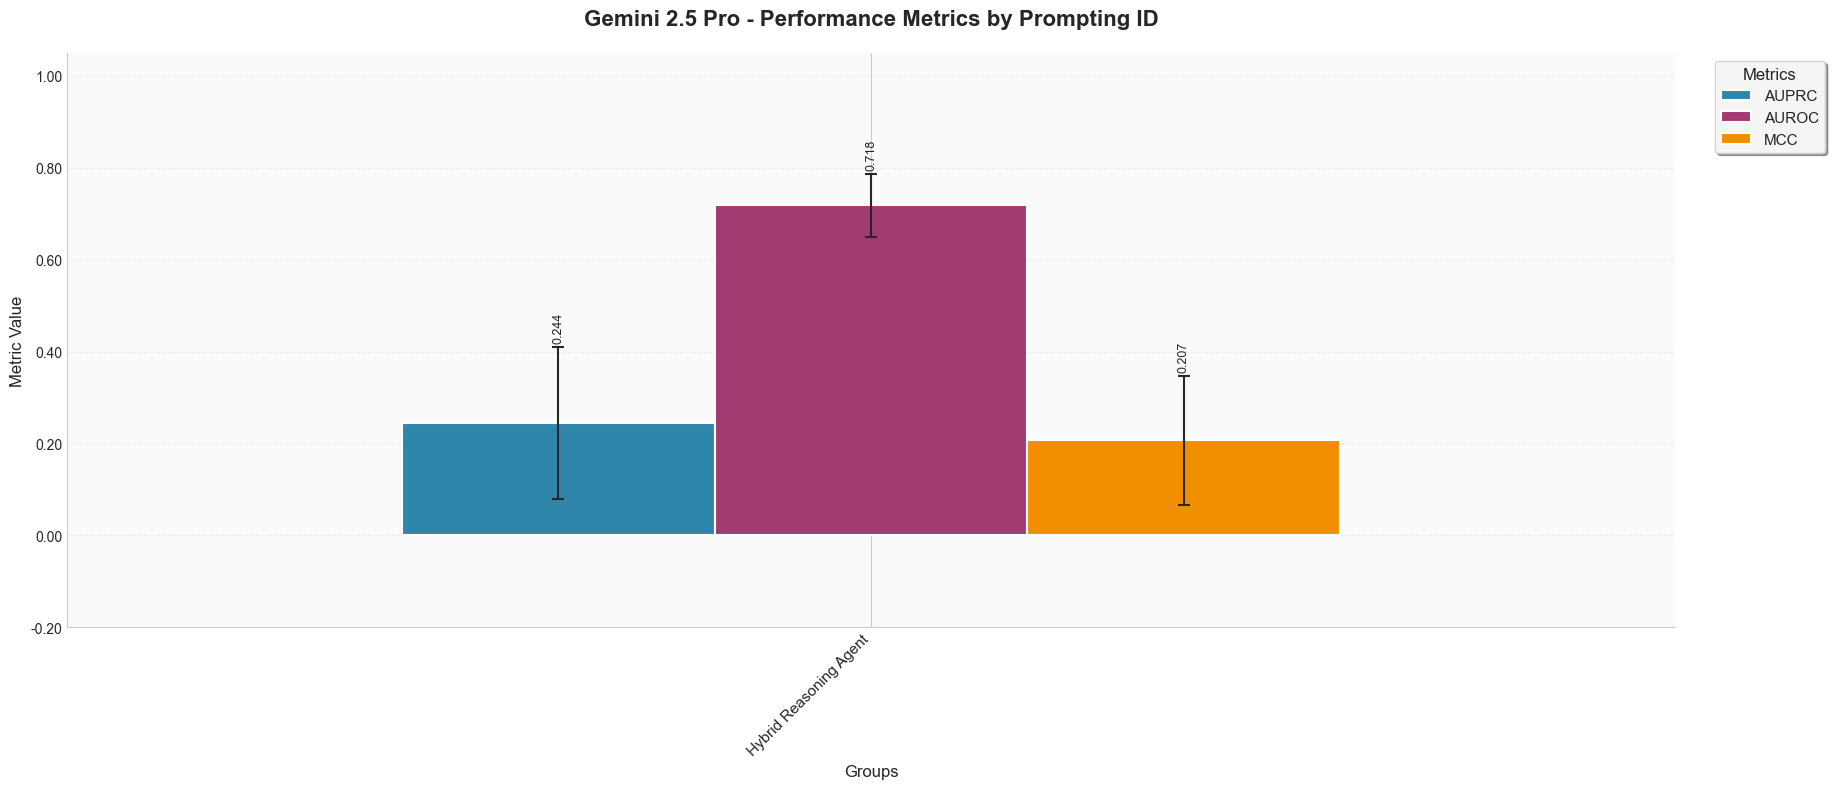

In [8]:
df_results = LLMAnalyzer.load_metrics_from_prompt_approaches(
    model_output_dir, prompt_approaches
)



LLMAnalyzer.plot_metrics(
    df_results, group=["prompting_id"], title_prefix="Gemini 2.5 Pro - "
)

Metrics per Prompt and Task

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:916: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


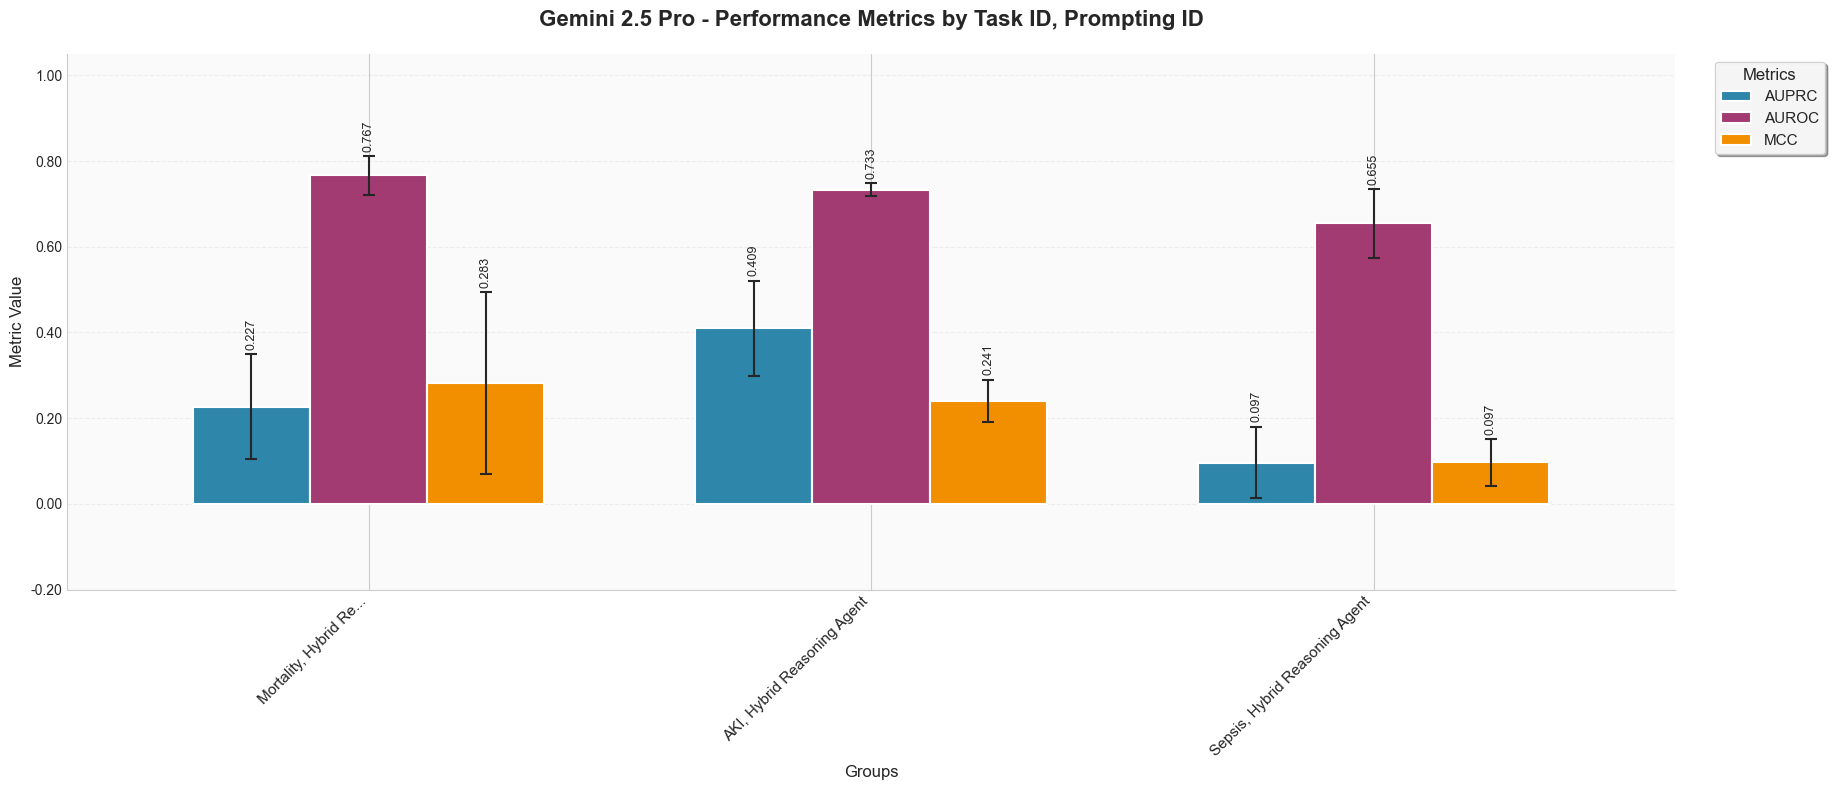

In [9]:
LLMAnalyzer.plot_metrics(
    df_results,
    group=["task_id", "prompting_id"],
    title_prefix="Gemini 2.5 Pro - ",
)

Analysis of best prompting approach

In [10]:
prompt_dropdown = widgets.Dropdown(
    options=prompt_approaches,
    value=best_prompt_approach[0],
    description='Prompt Approach:',
    style={'description_width': 'initial'}
)
display(prompt_dropdown)


Dropdown(description='Prompt Approach:', options=('hybrid_reasoning_agent_preprocessor',), style=DescriptionSt…

In [14]:
best_approach_path = os.path.join(
    model_output_dir, prompt_dropdown.value
)
print(f"Loading metadata from: {best_approach_path}")
print("======================================================")
cat_files = LLMAnalyzer.categorize_files([best_approach_path], verbose=False)
df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])

Loading metadata from: C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\llms\gemini2p5pro\hybrid_reasoning_agent_preprocessor
Model Name: Gemini2p5pro, Task: aki, Dataset: eicu, Timestamp: 20250712_173710
Model Name: Gemini2p5pro, Task: aki, Dataset: hirid, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: aki, Dataset: miiv, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: mortality, Dataset: eicu, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: mortality, Dataset: hirid, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: mortality, Dataset: miiv, Timestamp: 20250707_112055
Model Name: Gemini2p5pro, Task: sepsis, Dataset: eicu, Timestamp: 20250710_103102
Model Name: Gemini2p5pro, Task: sepsis, Dataset: hirid, Timestamp: 20250710_103102
Model Name: Gemini2p5pro, Task: sepsis, Dataset: miiv, Timestamp: 20250710_103102


In [15]:
LLMAnalyzer.print_approach_summary(df_mdata)

,task,dataset,mean_inference_time,total_inference_time,mean_input_tokens,total_input_tokens,mean_output_tokens,total_output_tokens,positive_samples,negative_samples,total_samples,pos_neg_ratio
0,aki,eicu,17.59s,80005.73s,671,3050926,143,648907,1476,3073,4549,0.48
1,aki,hirid,14.52s,62995.21s,665,2884303,137,594755,766,3572,4338,0.21
2,aki,miiv,15.75s,72282.80s,695,3188296,143,657601,1122,3467,4589,0.32
3,mortality,eicu,15.05s,6259.60s,650,270254,131,54343,32,384,416,0.08
4,mortality,hirid,14.96s,6358.34s,686,291459,133,56622,50,375,425,0.13
5,mortality,miiv,17.05s,7210.75s,666,281673,134,56667,56,367,423,0.15
6,sepsis,eicu,15.68s,66217.63s,686,2898957,141,594562,211,4012,4223,0.05
7,sepsis,hirid,15.42s,64985.78s,711,2996674,142,598623,338,3876,4214,0.09
8,sepsis,miiv,14.26s,60114.23s,679,2862772,139,585637,109,4106,4215,0.03


In [13]:
df_mdata

""


--- Prediction Distribution Statistics ---
Total Records: 300
Ground Truth Positive Samples: 30
Ground Truth Negative Samples: 270
Mean Predicted Probability (Average of All Predictions): 0.456
Std Predicted Probability: 0.330
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.356
True Positives: 23
True Negatives: 143
False Positives: 127
False Negatives: 7
Accuracy (at 0.5 threshold): 0.553
AUPRC: 0.482


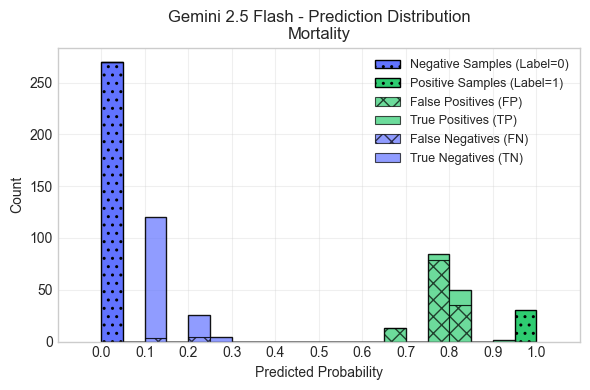

--- Prediction Distribution Statistics ---
Total Records: 2939
Ground Truth Positive Samples: 145
Ground Truth Negative Samples: 2794
Mean Predicted Probability (Average of All Predictions): 0.415
Std Predicted Probability: 0.338
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.366
True Positives: 103
True Negatives: 1761
False Positives: 1032
False Negatives: 42
Accuracy (at 0.5 threshold): 0.635
Could not calculate AUPRC: Input contains NaN.. Make sure sklearn.metrics.average_precision_score is available.


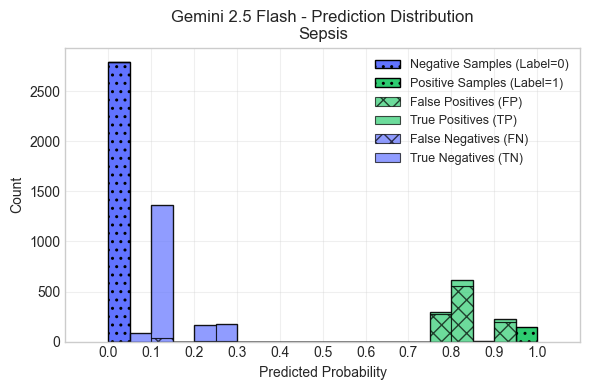

--- Prediction Distribution Statistics ---
Total Records: 2950
Ground Truth Positive Samples: 693
Ground Truth Negative Samples: 2257
Mean Predicted Probability (Average of All Predictions): 0.261
Std Predicted Probability: 0.331
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.026
True Positives: 260
True Negatives: 1897
False Positives: 360
False Negatives: 433
Accuracy (at 0.5 threshold): 0.731
AUPRC: 0.448


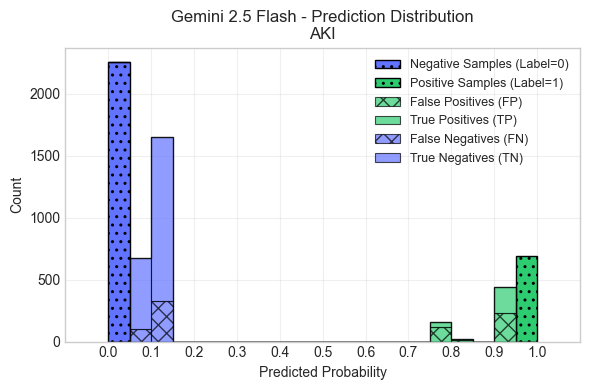

In [12]:
# Distribution of predictions
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["mortality"]},
    show_stats=True,
    color_neg="#6173FF", 
    color_pos="#2ECC71"  
)
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["sepsis"]},
    show_stats=True,
    color_neg="#6173FF",
    color_pos="#2ECC71",
)
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["aki"]},
    show_stats=True,
    color_neg="#6173FF",
    color_pos="#2ECC71",
)

---